# Handwritten Digit Recognition

This notebook demonstrates how to use PyTorch to build and train a simple neural network for handwritten digit recognition using the MNIST dataset.

The MNIST dataset contains 28x28 grayscale images of handwritten digits. The task is to classify each image into one of the 10 classes (0-9).

<img src="https://machinelearningmastery.com/wp-content/uploads/2019/02/Plot-of-a-Subset-of-Images-from-the-MNIST-Dataset.png" alt="Example Image" style="width:300px;height:200px;">

### Necessary Imports

We will import the required libraries to handle data loading, transformations, model building, and training.


In [ ]:
# Import necessary packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time

In [ ]:
import os
from google.colab import drive

### Download The Dataset & Define The Transforms

The MNIST dataset is available in torchvision. We will download it and define the necessary transformations to convert the images to tensors and normalize them.


In [ ]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
# - transforms.ToTensor() converts images to PyTorch tensors (and scales pixel values from [0,255] to [0,1])
# - transforms.Normalize((0.5,), (0.5,)) shifts and scales the data to have mean 0 and range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the MNIST training dataset
# - 'train=True' loads the training set
# - 'transform=transform' applies the defined transformations to the images
trainset = datasets.MNIST('drive/My Drive/mnist/MNIST_data/', download=True, train=True, transform=transform)

# Download and load the MNIST validation (test) dataset
# - 'train=False' loads the test set
valset = datasets.MNIST('drive/My Drive/mnist/MNIST_data/', download=True, train=False, transform=transform)

# Create a DataLoader for the training set
# - 'batch_size=64' means 64 images will be loaded at a time
# - 'shuffle=True' randomly shuffles the data every epoch for better training
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Create a DataLoader for the validation set
# - Same batch size and shuffling for validation
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 476kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.10MB/s]


### Exploring The Data

Let's visualize some sample images from the dataset to understand what the data looks like.


In [ ]:
# Check and display the type of the trainloader object (should be DataLoader)
type(trainloader)

torch.utils.data.dataloader.DataLoader

In [ ]:
# Create an iterator from the DataLoader
dataiter = iter(trainloader)

# Get the next batch of images and labels from the iterator
images, labels = next(dataiter)

# Print the type of 'images' (should be a torch.Tensor)
print(type(images))

# Print the shape of the 'images' tensor (should be [batch_size, channels, height, width])
print(images.shape)

# Print the shape of the 'labels' tensor (should be [batch_size])
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


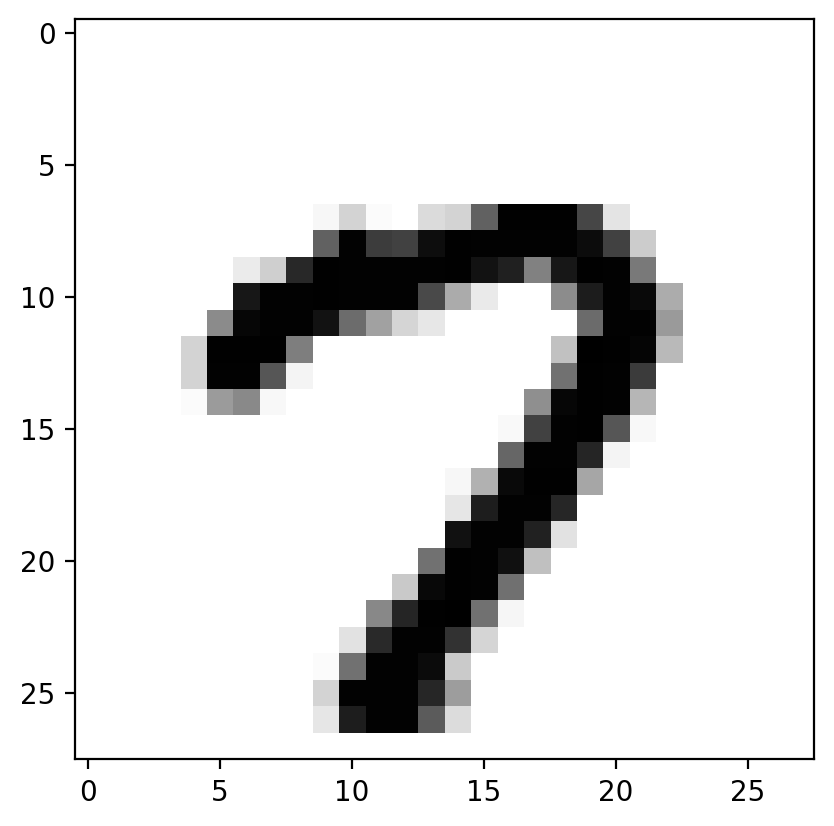

In [ ]:
# Display the first image in the batch by converting it to a NumPy array, squeezing extra dimensions, and using a grayscale colormap
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

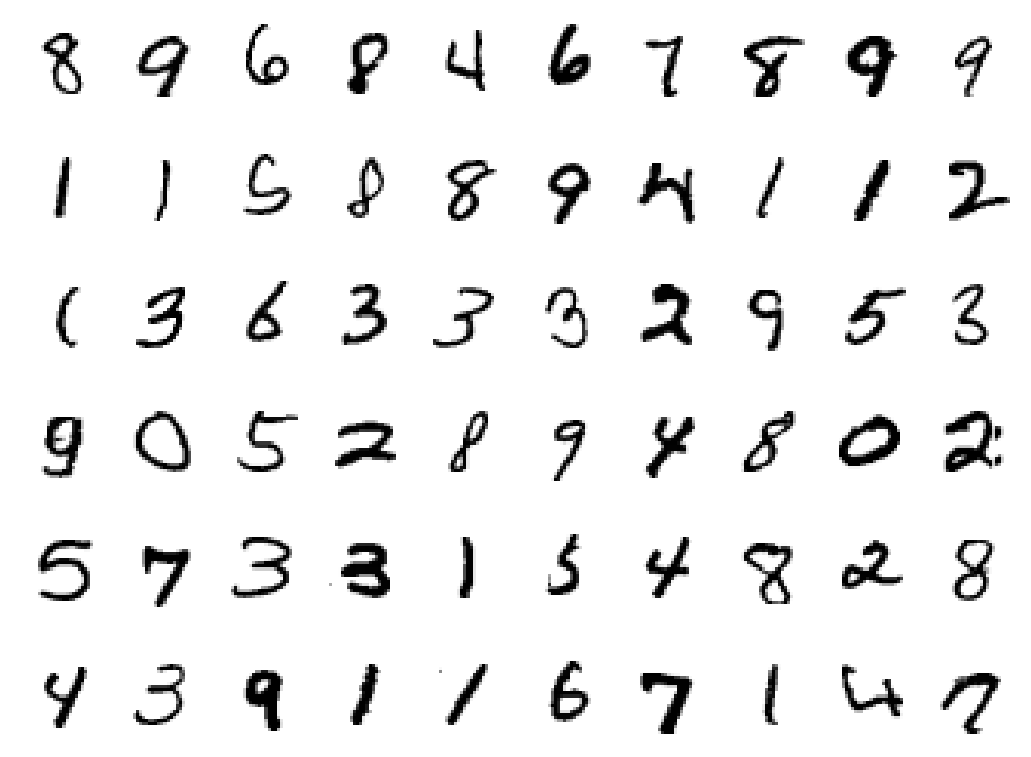

In [ ]:
# Create a new figure for plotting multiple images
figure = plt.figure()

# Set the number of images you want to display
num_of_images = 60

# Loop through the first 60 images
for index in range(1, num_of_images + 1):
    # Create a subplot grid of 6 rows and 10 columns, and select the current index
    plt.subplot(6, 10, index)

    # Turn off axis labels for a cleaner look
    plt.axis('off')

    # Display the image after converting it to a NumPy array and squeezing dimensions
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### Defining The Neural Network

![](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/image/mlp_mnist.png)

In [ ]:
from torch import nn

# Layer details for the neural network
input_size = 784            # Input layer size (28x28 images flattened to 784 features)
hidden_sizes = [128, 64]    # Two hidden layers with 128 and 64 neurons respectively
output_size = 10            # Output layer size (10 classes for digits 0-9)

# Build a feed-forward neural network using nn.Sequential
model = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),       # First hidden layer (784 -> 128)
    nn.ReLU(),                                    # Activation function (ReLU) after first layer
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),  # Second hidden layer (128 -> 64)
    nn.ReLU(),                                    # Activation function (ReLU) after second layer
    nn.Linear(hidden_sizes[1], output_size),      # Output layer (64 -> 10)
    nn.LogSoftmax(dim=1)                          # Log-Softmax for output probabilities across 10 classes
)

print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [ ]:
# Define the loss function (criterion)
criterion = nn.NLLLoss()
# NLLLoss = Negative Log Likelihood Loss (used with LogSoftmax outputs)

# Get a batch of training images and labels
images, labels = next(iter(trainloader))

# Flatten the images from (batch_size, 1, 28, 28) to (batch_size, 784) using view()
images = images.view(images.shape[0], -1)

# Forward pass: pass the images through the model to get log probabilities
logps = model(images)

# Calculate the loss between the model's predictions and the true labels
loss = criterion(logps, labels)

In [ ]:
# Print the gradient of the weights of the first layer BEFORE doing backpropagation
print('Before backward pass: \n', model[0].weight.grad)

# Perform backpropagation to compute gradients
loss.backward()

# Print the gradient of the weights of the first layer AFTER backpropagation
print('After backward pass: \n', model[0].weight.grad)

In [ ]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [ ]:
# Print the initial weights of the first linear layer before any training
print('Initial weights - ', model[0].weight)

# Get a batch of images and labels from the training data
images, labels = next(iter(trainloader))

# Reshape the images to match the input size of the network (flatten 28x28 to 784)
images.resize_(64, 784)

# Clear previously accumulated gradients (important because by default PyTorch accumulates gradients)
optimizer.zero_grad()

# Forward pass: compute the network output
output = model(images)

# Compute the loss between the predicted output and true labels
loss = criterion(output, labels)

# Backward pass: compute the gradients of the loss with respect to the weights
loss.backward()

# Print the computed gradients for the first layer's weights after backpropagation
print('Gradient -', model[0].weight.grad)

In [ ]:
# Take an update step: adjust the model weights using the computed gradients
optimizer.step()

# Print the updated weights of the first linear layer after the optimizer step
print('Updated weights - ', model[0].weight)

### Training Of Neural Network

In [ ]:
# Define the optimizer: using Stochastic Gradient Descent (SGD) with learning rate 0.003 and momentum 0.9
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

# Record the start time to measure how long training takes
time0 = time()

# Set the number of training epochs (full passes through the dataset)
epochs = 15

# Training loop
for e in range(epochs):
    running_loss = 0  # To track the loss during this epoch

    for images, labels in trainloader:
        # Flatten the MNIST images into a 784-dimensional vector
        images = images.view(images.shape[0], -1)

        # Clear the gradients to prevent accumulation from previous steps
        optimizer.zero_grad()

        # Forward pass: predict the labels
        output = model(images)

        # Compute the loss between predicted and true labels
        loss = criterion(output, labels)

        # Backward pass: compute the gradients
        loss.backward()

        # Update the weights using the optimizer
        optimizer.step()

        # Accumulate the running loss
        running_loss += loss.item()

    else:
        # After the epoch, print the average training loss
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))

# After training, print total training time in minutes
print("\nTraining Time (in minutes) =", (time()-time0)/60)

In [ ]:
def view_classify(img, ps):
    '''
    Function for viewing an image and its predicted class probabilities.
    Args:
        img: a single image tensor
        ps: output probabilities (predictions) from the model
    '''

    # Remove unnecessary dimensions and convert the tensor to a NumPy array
    ps = ps.data.numpy().squeeze()

    # Create a figure with two side-by-side subplots
    fig, (ax1, ax2) = plt.subplots(figsize=(6, 9), ncols=2)

    # Display the image on the first subplot
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())  # Resize to (1,28,28) for visualization
    ax1.axis('off')  # Hide axis lines and labels

    # Display the class probabilities as a horizontal bar chart on the second subplot
    ax2.barh(np.arange(10), ps)  # Create horizontal bars for each of the 10 classes
    ax2.set_aspect(0.1)  # Set aspect ratio for better appearance
    ax2.set_yticks(np.arange(10))  # Set y-axis ticks at class labels 0–9
    ax2.set_yticklabels(np.arange(10))  # Label y-axis with the class numbers
    ax2.set_title('Class Probability')  # Title for the probability plot
    ax2.set_xlim(0, 1.1)  # Set x-axis range to show probabilities between 0 and 1.1

    # Adjust the layout so the plots don't overlap
    plt.tight_layout()


In [ ]:
# Get a batch of validation images and labels
images, labels = next(iter(valloader))

# Select the first image and reshape it into a vector of size (1, 784)
img = images[0].view(1, 784)

# Turn off gradient tracking for inference to make it faster and save memory
with torch.no_grad():
    # Pass the image through the model to get log-probabilities
    logps = model(img)

# Convert log-probabilities to actual probabilities
ps = torch.exp(logps)

# Convert the probabilities tensor to a list for easier handling
probab = list(ps.numpy()[0])

# Find the index (digit) with the highest probability
print("Predicted Digit =", probab.index(max(probab)))

# Visualize the image along with the predicted class probabilities
view_classify(img.view(1, 28, 28), ps)


### Model Evaluation

We will evaluate the model on the test dataset and visualize some predictions.


In [ ]:
# Initialize counters for correct predictions and total predictions
correct_count, all_count = 0, 0

# Loop through all validation images and labels
for images, labels in valloader:
    # Loop through each image in the batch
    for i in range(len(labels)):
        # Flatten the image into a vector of size (1, 784)
        img = images[i].view(1, 784)

        # Turn off gradients during inference for efficiency
        with torch.no_grad():
            # Get the log-probabilities from the model
            logps = model(img)

        # Convert log-probabilities to normal probabilities
        ps = torch.exp(logps)

        # Get the probabilities as a list
        probab = list(ps.numpy()[0])

        # Get the predicted label (class with the highest probability)
        pred_label = probab.index(max(probab))

        # Get the true label
        true_label = labels.numpy()[i]

        # Compare prediction to the true label
        if true_label == pred_label:
            correct_count += 1
        all_count += 1

# Print the total number of images tested
print("Number Of Images Tested =", all_count)

# Calculate and print the accuracy of the model
print("\nModel Accuracy =", (correct_count / all_count))

### Conclusion

In this notebook, we successfully built and trained a simple neural network using PyTorch to recognize handwritten digits. This introduction to PyTorch provides the foundation for more complex models and deeper exploration.
